In [106]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchlake.sequence_data.models import Tcn

# data


In [71]:
artifact_path = Path("../../artifacts/tcn")

In [72]:
# samsung
data = web.DataReader("005930", "naver", datetime(2018, 1, 1), datetime.today()).astype(
    np.float32
)

<Axes: xlabel='Date'>

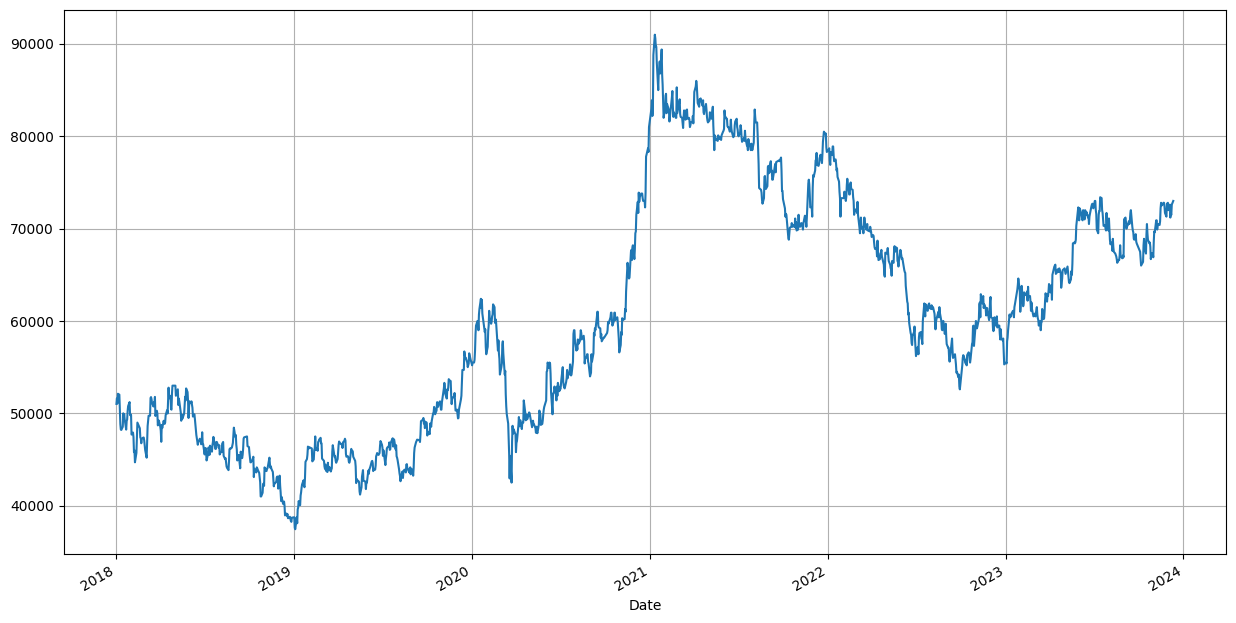

In [73]:
data["Close"].plot(figsize=(15, 8), grid=True)

In [74]:
def preprocess_data(x: np.array, seq_len: int) -> np.array:
    return np.array(
        [x[i : i + seq_len] for i in range(len(x)) if (i + seq_len) < len(x) - 1]
    )

In [75]:
def preprocess_label(series: np.array, seq_len: int) -> np.array:
    return np.array(
        [
            series[i + seq_len + 1]
            for i in range(len(series))
            if (i + seq_len + 1) < len(series)
        ]
    ).reshape(-1, 1)

In [76]:
time_step = 5

In [77]:
TS = preprocess_data(data["Close"].to_numpy(), time_step + 1)

In [78]:
train_ts, test_ts = train_test_split(TS, test_size=1/5)

In [79]:
TS_LABEL = preprocess_label(data["Close"].to_numpy(), time_step)

In [80]:
dataset = TensorDataset(torch.from_numpy(train_ts[:, :time_step]), torch.from_numpy(train_ts[:, -1]))
loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

# model


In [81]:
device = torch.device("cuda:0")

In [82]:
model = Tcn(
    input_dim=1,
    num_channels=[1, 32, 64, 128, 1],
    kernel_size=time_step,
    dropout=0.2,
).to(device)

# training


In [83]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [84]:
epochs = 30

In [85]:
model.train()
for e in range(epochs):
    running_loss = 0.0
    
    for past, future in loader:
        optimizer.zero_grad()

        past = past.unsqueeze(1).float().to(device)
        future = future.float().to(device)

        output = model(past)[:, :, -1].reshape(-1)

        loss = criterion(output, future)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    print(f"epoch {e+1}: {running_loss/len(dataset)}")

epoch 1: 21433748.144082334
epoch 2: 715593.6282161234
epoch 3: 352668.5222984563
epoch 4: 300543.18439108063
epoch 5: 257906.44511149227
epoch 6: 203519.8807890223
epoch 7: 186374.3441252144
epoch 8: 149046.0433104631
epoch 9: 124359.21633790738
epoch 10: 103016.59648370497
epoch 11: 84894.17227701543
epoch 12: 83530.29288164666
epoch 13: 66579.23295454546
epoch 14: 63857.36610205832
epoch 15: 55847.76677744425
epoch 16: 50809.78473413379
epoch 17: 47916.60999142367
epoch 18: 49105.56721698113
epoch 19: 45695.818289022296
epoch 20: 40072.44870283019
epoch 21: 40427.372695111495
epoch 22: 38397.73126608062
epoch 23: 36672.64284948542
epoch 24: 38258.41975771869
epoch 25: 36725.727862349915
epoch 26: 33899.42308104631
epoch 27: 34876.48156089194
epoch 28: 36180.22603987993
epoch 29: 31159.294489708405
epoch 30: 30547.177958833618


# inference


In [109]:
model.eval()
with torch.no_grad():
    test_x = torch.from_numpy(test_ts)[:, :time_step].unsqueeze(1).float().to(device)
    test_y = test_ts[:, -1].reshape(-1).astype(np.float32)
    forecasting = model(test_x)[:, :, -1].view(-1).tolist()
    print(mean_squared_error(test_y, forecasting))

975333.9655970744


In [111]:
model.eval()
with torch.no_grad():
    x = torch.from_numpy(TS)[:, :time_step].unsqueeze(1).float().to(device)
    forecasting = model(x)[:, :, -1].view(-1).tolist()

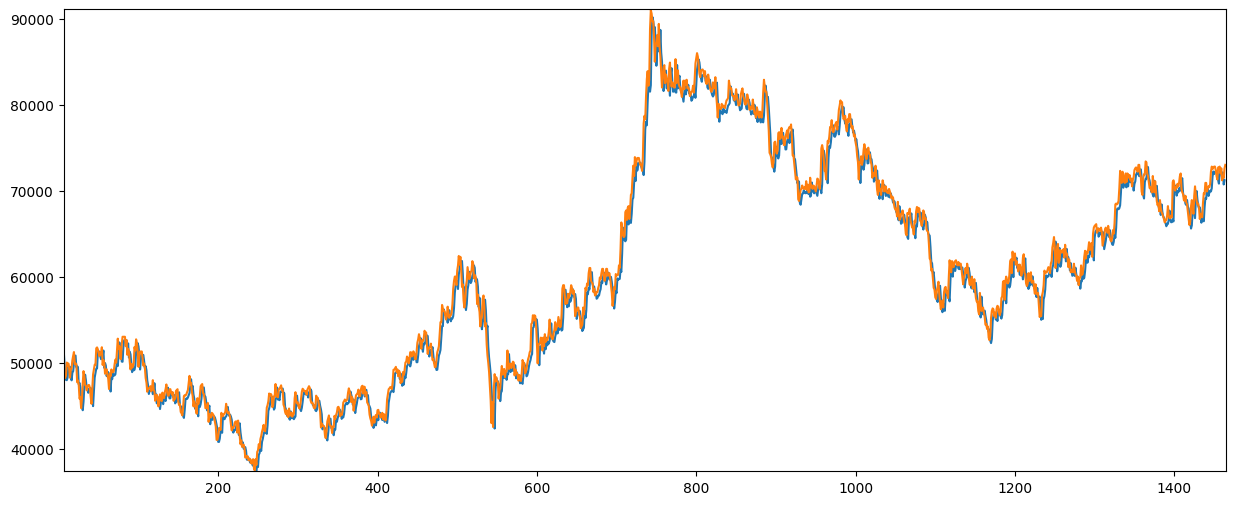

In [113]:
plt.figure(figsize=(15, 6))
plt.xlim(time_step + 1, len(data))
plt.ylim(data["Close"].min() - 100, data["Close"].max() + 100)
plt.plot(np.pad(forecasting, (time_step + 1, 0), mode="constant"))
plt.plot(data["Close"].to_numpy())

In [23]:
model_path = artifact_path.joinpath("tcn.pth")
onnx_model_path = artifact_path.joinpath("tcn.onnx")

In [24]:
torch.save(model.state_dict(), model_path)

In [25]:
torch.onnx.export(model, torch.randn(1, 1, 5).to(device), onnx_model_path)